# Descripción del Proyecto

Vamos a preparar un prototipo de un modelo de **Machine Learning** para *Zyfra*. La empresa que desarrolla soluciones de eficiencia para la industria pesada.

El modelo debe predecir la cantidad de oro extraído del mineral de oro. Dispones de los datos de extracción y purificación.

# Datos

Los datos se indexan con la fecha y la hora de adquisición (`date`). Los parámetros cercanos en el tiempo suelen ser similares.

Algunos parámetros no están disponibles porque fueron medidos o calculados mucho más tarde. Por eso, algunas de las características que están presentes en el conjunto de entrenamiento pueden estar ausentes en el conjunto de prueba. El conjunto de prueba tampoco contiene objetivos.

El dataset fuente contiene los conjuntos de entrenamiento y prueba con todas las características.
Tienes a tu disposición los datos en bruto que solamente fueron descargados del almacén de datos. Antes de construir el modelo, comprueba que los datos sean correctos. Para ello, utiliza nuestras instrucciones.

## Descripción de datos

### Proceso tecnológico

* *Rougher feed* — materia prima
* *Rougher additions* (o adiciones de reactivos) - reactivos de flotación: xantato, sulfato, depresante
* *Xantato* — promotor o activador de la flotación
* *Sulfato* — sulfuro de sodio para este proceso en particular
* *Depresante* — silicato de sodio
* *Rougher process* — flotación
* *Rougher tails* — residuos del producto
* *Float banks* — instalación de flotación
* *Cleaner process* — purificación
* *Rougher Au* — concentrado de oro rougher
* *Final Au* — concentrado de oro final

### Parámetros de las etapas

* *air amount* — volumen de aire
* *fluid levels*
* *feed size* — tamaño de las partículas de la alimentación
* *feed rate*

## Denominación de las características

Así es como se denominan las características:

`[stage].[parameter_type].[parameter_name]` 

Ejemplo: `rougher.input.feed_ag`

Valores posibles para `[stage]`:

* *rougher* — flotación
* *primary_cleaner* — purificación primaria
* *secondary_cleaner* — purificación secundaria
* *final* — características finales

Valores posibles para `[parameter_type]`:

* *input* — parámetros de la materia prima
* *output* — parámetros del producto
* *state* — parámetros que caracterizan el estado actual de la etapa
* *calculation* — características de cálculo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score

In [2]:
data_full = pd.read_csv('gold_recovery_full.csv')
data_train = pd.read_csv('gold_recovery_train.csv')
data_test = pd.read_csv('gold_recovery_test.csv')

In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
data_train.isna().sum().values

array([   0,   72,   72,  370,   71, 1521,   66,  183,  145,   66, 1307,
       1262,    0,  985,   82,  358,  636,   82,   83,   99,  281,   83,
         40,   33,   40,   27,   38,   27,   39,   27,   27,   27,   27,
       1242,   82,  228,  513,  417,  292,   83, 1044,  346,  623, 1904,
         82,   82,  162,   82, 2573, 2250,   82, 2249, 2249,   53,   53,
         53,   53,   53,   46,   58,   51,  603,   51,   58,   58,   84,
         96, 1986,   82,  363,  109,  155,  112,   97,  113,  108,  110,
        129,  113,   92,   93,   85,   85,   85,   84,  103,   85],
      dtype=int64)

In [5]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [6]:
data_train.isna().sum()[data_train.isna().sum().values > 1000]

final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
rougher.input.floatbank10_sulfate     1044
rougher.input.floatbank11_xanthate    1904
rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
dtype: int64

En el conjunto de `entrenamiento` observamos lo siguiente:

* Todas las columnas tienen valores ausentes, excepto la columna `date`. Existen algunas características con más de `1000` valores ausentes como las que se muestran anteriormente. 

* La columna `date` no está en el formato `datetime`.

In [7]:
data_train['date'] = pd.to_datetime(data_train['date'], infer_datetime_format = True)
data_test['date'] = pd.to_datetime(data_test['date'], infer_datetime_format = True)
data_full['date'] = pd.to_datetime(data_full['date'], infer_datetime_format = True)

Hemos cambiado el tipo de la columna `date` al formato correcto en los tres conjuntos de datos.

In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64       
 9   primary_

In [9]:
data_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


En los datos de `prueba` observamos lo siguiente:

* Se tienen menos columnas. En el conjunto de `entranamiento` son 87 y en el conjunto de `prueba` son 53. Es decir, tenemos menos características medidas que en el de entrenamiento. 

* El dataset casi todas las columnas tienen valores ausentes, salvo las columnas `date` y `primary_cleaner.input.feed_size`.

* Ya hemos cambiado el formato de la variable `date` al formato correcto. 

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

In [11]:
data_full.isna().sum().values

array([   0,   89,   87,  385,   86, 1963,   83,  200,  271,   81, 1609,
       1546,    0, 1151,   98,  448,  798,   98,  102,  122,  351,   99,
         56,   49,   56,   43,   54,   43,   55,   43,   44,   44,   44,
       1627,   98,  244,  553,  439,  359,   99, 1301,  469,  678, 2257,
         98,   98,  190,   98, 3119, 2737,   98, 2736, 2736,   70,   69,
         70,   69,   70,   62,   75,   67,  620,   67,   75,   74,  100,
        116, 2215,   98,  383,  125,  178,  128,  131,  129,  124,  126,
        145,  129,  108,  109,  101,  101,  101,  100,  119,  101],
      dtype=int64)

El DataFrame `data_full` parece que contiene la información completa, la que aparece en los datos de entrenamiento y la de los datos de prueba (con las variables que faltaban ya medidas).

# Preprocesamiento de los datos

## Comprobando que el cálculo de la recuperación sea correcto

In [12]:
C = data_train['rougher.output.concentrate_ag'].dropna()

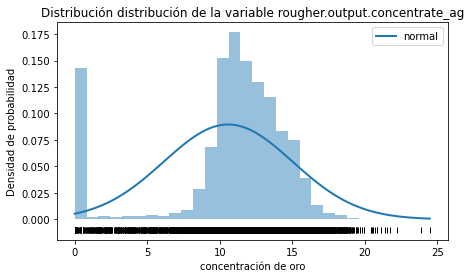

In [13]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(C)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(C), max(C), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=C, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(C, np.full_like(C, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución distribución de la variable rougher.output.concentrate_ag')
ax.set_xlabel('concentración de oro')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [14]:
F = data_train['rougher.input.feed_ag'].dropna()

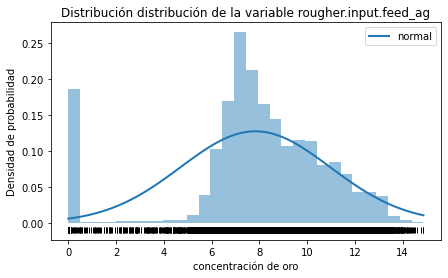

In [15]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(F)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(F), max(F), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=F, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(F, np.full_like(F, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución distribución de la variable rougher.input.feed_ag')
ax.set_xlabel('concentración de oro')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

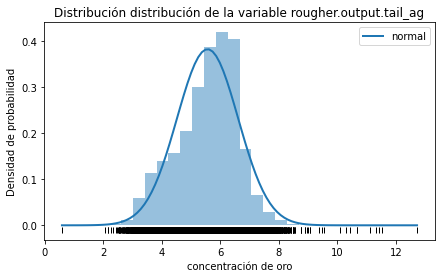

In [16]:
T = data_train['rougher.output.tail_ag'].dropna()

# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(T)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(T), max(T), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=T, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(T, np.full_like(T, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución distribución de la variable rougher.output.tail_ag')
ax.set_xlabel('concentración de oro')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [17]:
def recovery_calculation(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    if (np.isnan(C)) | (np.isnan(T)) | (np.isnan(F)):
        return np.nan 
    elif (F==0) | (C == T):
        return 0
    else:
        return (C*(F - T))/(F*(C - T))*100
data_train['rougher.output.recovery_calculated'] = data_train.apply(recovery_calculation, axis = 1)

In [18]:
recovery = data_train[['rougher.output.recovery', 'rougher.output.recovery_calculated']]
recovery = recovery.dropna()

In [19]:
recovery.head()

,rougher.output.recovery,rougher.output.recovery_calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794


In [20]:
mean_squared_error(recovery['rougher.output.recovery'], recovery['rougher.output.recovery_calculated'], squared = False)

1.40384366032228e-14

Hemos obtenido un error cuadrático medio muy pequeño, luego podemos decir que la columna `rougher.output.recovery` parece estar bien calculada, según la fórmula.

In [21]:
data_train = data_train.drop(columns = 'rougher.output.recovery_calculated')

Ya no vamos a usar más la columna `rougher.output.recovery_calculated`, luego la vamos a eliminar del DataFrame.  

In [22]:
columns_train = list(data_train.columns)
columns_test = list(data_test.columns)

In [23]:
differential_columns = []
count = 0
for col in columns_train:
    if col not in columns_test:
        differential_columns.append(col)
        count += 1

In [24]:
differential_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [25]:
count

34

La cantidad de variables que no se han medido en el dataset de prueba son 34, relacionadas con las salidas (**outputs**) de cada una de las etapas y con algunos parámetros de la etapa de **flotación**.

## Tratando los datos faltantes en cada uno de los datasets: `data_train`, `data_test` y `data_full`

In [26]:
data_train = data_train.sort_values('date')
data_test = data_test.sort_values('date')
data_full = data_full.sort_values('date')

In [27]:
data_train = data_train.fillna(method = 'ffill')
data_test = data_test.fillna(method = 'ffill')
data_full = data_full.fillna(method = 'ffill')

Hemos ordenado el los datasets por fecha, para que las mediciones cercanas en tiempo esten cercanas en el DataFrame. En función de esto, rellenamos los valores faltantes con las mediciones cercanas válidas, es decir, usamos el método `ffill` de `fillna`. Con esto ya no tenemos valores faltantes. 

# Análisis de los datos

## Concentración de los metales (`Au`, `Ag` y `Pb`) en función de las etapas

### Variación de la concentración de `Ag` en cada etapa

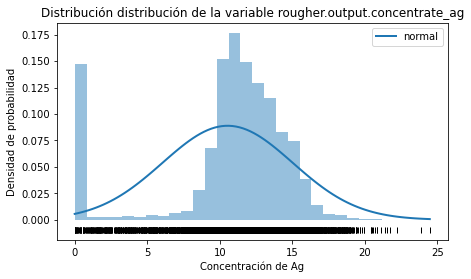

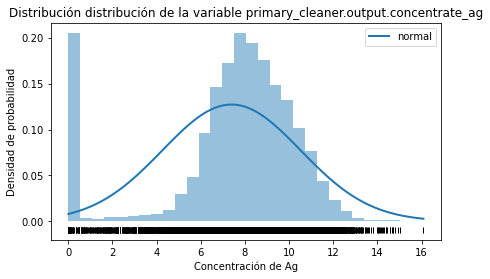

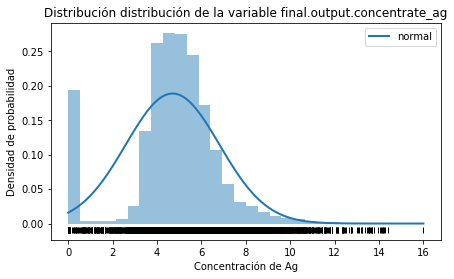

In [28]:
stage_Ag_con = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
for st in stage_Ag_con:
    S = data_train[st]

    # Histograma + curva normal teórica
    # ==============================================================================

    # Valores de la media (mu) y desviación típica (sigma) de los datos
    mu, sigma = stats.norm.fit(S)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(S), max(S), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(x_hat, y_hat, linewidth=2, label='normal')
    ax.hist(x=S, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(S, np.full_like(S, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Distribución distribución de la variable ' + st)
    ax.set_xlabel('Concentración de Ag')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

En cada caso, se observa un apalancamiento de la distribución y una barra (**muy similar en cada etapa en altura y amplitud**) cercana al valor `cero`. Esto último puede deberse a mezclas que tienen baja concentración de `Ag` la salida en cada etapa del proceso va a tener también bajas concentraciones de `Ag`.

Finalmente, se observa que en la etapa de flotación la distribución está sesgada a la derecha, siendo los valores de concentración más altos los más frecuentes. A medida que pasan los procesos, la distribución se va corriendo a la izquierda siendo los valores más pequeños los más frecuentes. Esto tiene mucho sentido porque cuando avanza el proceso de purificación disminuye la concentración. 

## Variación de la concentración de `Pb` en cada etapa


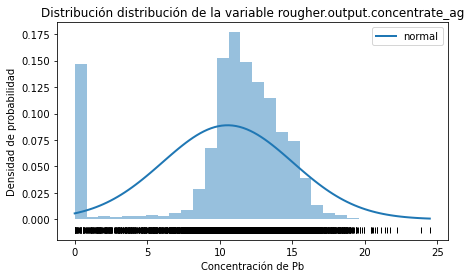

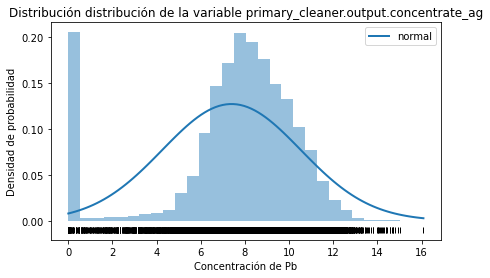

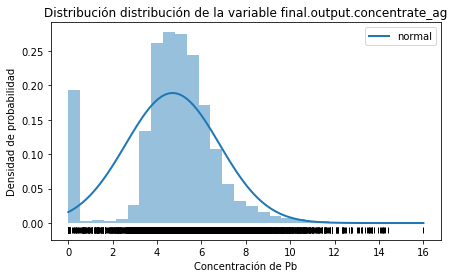

In [32]:
stage_Pb_con = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
for st in stage_Ag_con:
    S = data_train[st]

    # Histograma + curva normal teórica
    # ==============================================================================

    # Valores de la media (mu) y desviación típica (sigma) de los datos
    mu, sigma = stats.norm.fit(S)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(S), max(S), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(x_hat, y_hat, linewidth=2, label='normal')
    ax.hist(x=S, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(S, np.full_like(S, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Distribución distribución de la variable ' + st)
    ax.set_xlabel('Concentración de Pb')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

Sucede lo mismo que con la concentración de `Ag`. A medida que avanza el proceso, se logran menores niveles del metal `Pb`.

## Variación de la concentración de `Au` en cada etapa

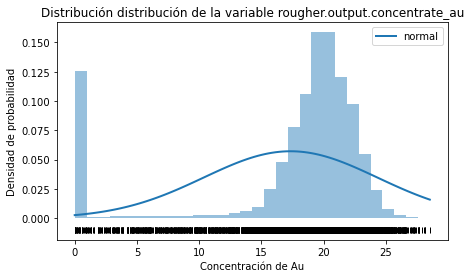

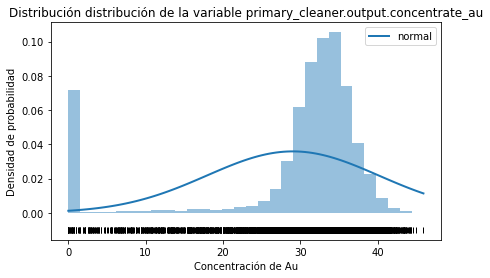

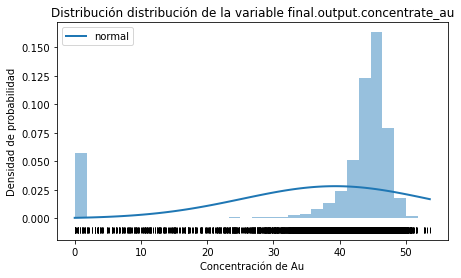

In [33]:
stage_Au_con = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
for st in stage_Au_con:
    S = data_train[st]

    # Histograma + curva normal teórica
    # ==============================================================================

    # Valores de la media (mu) y desviación típica (sigma) de los datos
    mu, sigma = stats.norm.fit(S)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(S), max(S), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(x_hat, y_hat, linewidth=2, label='normal')
    ax.hist(x=S, density=True, bins=30, color="#3182bd", alpha=0.5)
    ax.plot(S, np.full_like(S, -0.01), '|k', markeredgewidth=1)
    ax.set_title('Distribución distribución de la variable ' + st)
    ax.set_xlabel('Concentración de Au')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

A diferencia de lo que sucede con los otros metales, en el caso del `Au` la distribución se traslada en cada proceso a la derecho, donde las concentraciones más probables son las más grandes. En ese sentido, la concentración de salida final es `40` a `50` y hay mucho menos dispersión de los datos. 

## Comparando las distribuciones del tamaño de las particulas en los subconjuntos de entrenamiento y prueba

In [34]:
feed_size_columns = []
for col in data_test.columns:
    if 'feed_size' in col:
        feed_size_columns.append(col)
feed_size_columns

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

In [35]:
feed_size_columns = []
for col in data_train.columns:
    if 'feed_size' in col:
        feed_size_columns.append(col)
feed_size_columns

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Las variables que miden el parámetro de tamaño de las partículas de entrada son `rougher.input.feed_size` y `primary_cleaner.input.feed_size` en las etapas de **flotación** y **limpieza primaria**, respectivamente. Ambos parametros están medidos en los conjuntos de entrenamiento y prueba. 

### Etapa de flotación

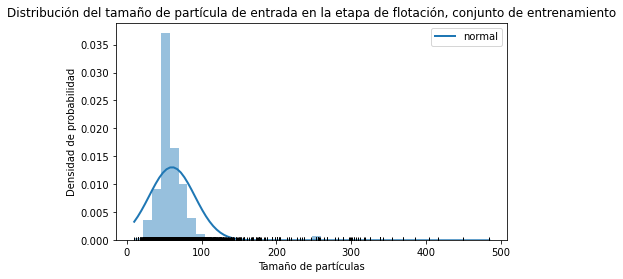

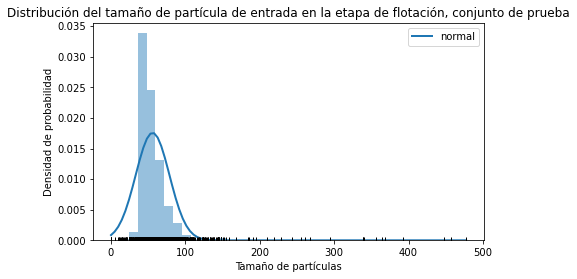

In [36]:
feed_size_rougher = [data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size']]
titles = ['entrenamiento', 'prueba']
for S, t in zip(feed_size_rougher, titles):
    
    # Histograma + curva normal teórica
    # ==============================================================================

    # Valores de la media (mu) y desviación típica (sigma) de los datos
    mu, sigma = stats.norm.fit(S)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(S), max(S), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(x_hat, y_hat, linewidth=2, label='normal')
    ax.hist(x=S, density=True, bins=40, color="#3182bd", alpha=0.5)
    ax.plot(S, np.full_like(S, 0), '|k', markeredgewidth=1)
    ax.set_title('Distribución del tamaño de partícula de entrada en la etapa de flotación, conjunto de ' + t)
    ax.set_xlabel('Tamaño de partículas')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

Las distribuciones parecen muy similares. 

### Etapa de limpieza primaria

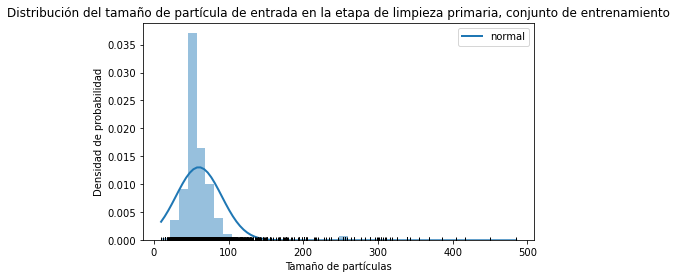

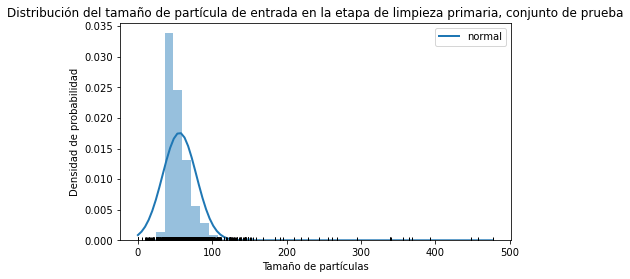

In [37]:
feed_size_primary = [data_train['primary_cleaner.input.feed_size'], data_test['primary_cleaner.input.feed_size']]
titles = ['entrenamiento', 'prueba']
for S, t in zip(feed_size_rougher, titles):
    
    # Histograma + curva normal teórica
    # ==============================================================================

    # Valores de la media (mu) y desviación típica (sigma) de los datos
    mu, sigma = stats.norm.fit(S)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(S), max(S), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráfico
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(x_hat, y_hat, linewidth=2, label='normal')
    ax.hist(x=S, density=True, bins=40, color="#3182bd", alpha=0.5)
    ax.plot(S, np.full_like(S, 0), '|k', markeredgewidth=1)
    ax.set_title('Distribución del tamaño de partícula de entrada en la etapa de limpieza primaria, conjunto de ' + t)
    ax.set_xlabel('Tamaño de partículas')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

En este caso, también las distribuciones parecen muy similares. 

## Estudiando la distribución de las concentraciones totales de todas las sustancias en las diferentes etapas

### Datos de entrenamiento

In [38]:
data_train['rougher.input.feed_total'] = data_train['rougher.input.feed_ag'] + data_train['rougher.input.feed_pb'] + data_train['rougher.input.feed_au'] + data_train['rougher.input.feed_sol']
data_train['rougher.output.concentrate_total'] = data_train['rougher.output.concentrate_ag'] + data_train['rougher.output.concentrate_pb'] + data_train['rougher.output.concentrate_au'] + data_train['rougher.output.concentrate_sol']
data_train['final.output.concentrate_total'] = data_train['final.output.concentrate_ag'] + data_train['final.output.concentrate_pb'] + data_train['final.output.concentrate_au'] + data_train['final.output.concentrate_sol']

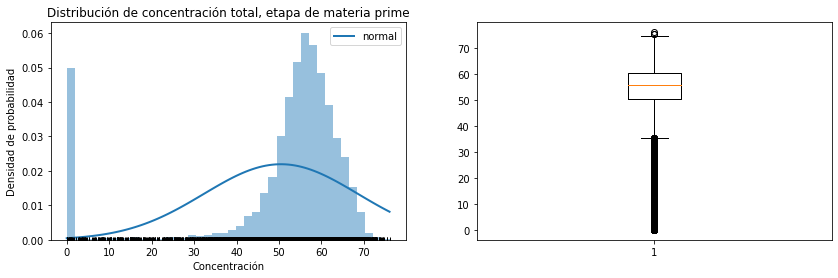

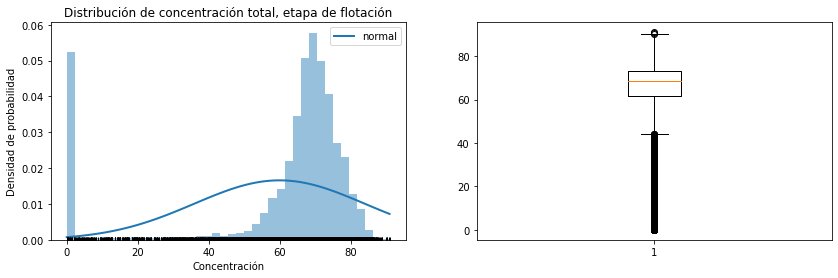

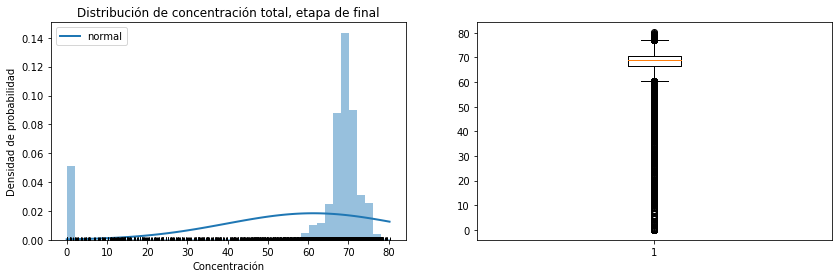

In [39]:
columns = ['rougher.input.feed_total', 'rougher.output.concentrate_total', 'final.output.concentrate_total']
etapas = ['materia prime', 'flotación', 'final']

for col, eta in zip(columns, etapas):
    S = data_train[col]
    # Histograma + curva normal teórica
    # ==============================================================================

    # Valores de la media (mu) y desviación típica (sigma) de los datos
    mu, sigma = stats.norm.fit(S)

    # Valores teóricos de la normal en el rango observado
    x_hat = np.linspace(min(S), max(S), num=100)
    y_hat = stats.norm.pdf(x_hat, mu, sigma)

    # Gráficos
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].plot(x_hat, y_hat, linewidth=2, label='normal')
    ax[0].hist(x=S, density=True, bins=40, color="#3182bd", alpha=0.5)
    ax[0].plot(S, np.full_like(S, 0), '|k', markeredgewidth=1)
    ax[0].set_title('Distribución de concentración total, etapa de ' + eta)
    ax[0].set_xlabel('Concentración')
    ax[0].set_ylabel('Densidad de probabilidad')
    ax[0].legend();
    ax[1].boxplot(S)

En cada etapa, las distribuciones tienen datos en común. Por ejemplo, están sezgadas a la derecha, tienen muchos valores atípicos por debajo de la concentración teórica y, además, existe una cantidad barra cercana a la concentración nula. Esta última barra puede estar relacionado materias primas que tienen muy bajas concentraciones de todos los materiales.

Vamos a ver si tenemos observaciones con concentraciones nulas.

In [40]:
l1 = len(data_train[data_train['rougher.input.feed_total'] == 0])
l2 = len(data_train[data_train['rougher.output.concentrate_total'] == 0])
l3 = len(data_train[data_train['final.output.concentrate_total'] == 0])
print(f'Para la concentración total de materia prima se tienen {l1} asociadas a concentraciones nulas.' )
print(f'Para la concentración total en la etapa de la flotación se tienen {l2} asociadas a concentraciones nulas.')
print(f'Para la concentración total final se tienen {l3} asociadas a concentraciones nulas.')

Para la concentración total de materia prima se tienen 1213 asociadas a concentraciones nulas.
Para la concentración total en la etapa de la flotación se tienen 1547 asociadas a concentraciones nulas.
Para la concentración total final se tienen 1320 asociadas a concentraciones nulas.


Proponemos eliminar del análisis estás observaciones. 

In [41]:
columns_total = {
    'rougher.input.feed_total':['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.input.feed_sol'],
    'rougher.output.concentrate_total':['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au', 'rougher.output.concentrate_sol'],
    'final.output.concentrate_total':['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au', 'final.output.concentrate_sol']
}
for col in list(columns_total.keys()):
    if 'input' in col:
        data_test[col] = 0
        for col1 in columns_total[col]:
            data_test[col] += data_test[col1]
        data_test = data_test[data_test[col] > 0].reset_index()
    else:
        data_train[col] = 0
        data_full[col] = 0
        for col1 in columns_total[col]:
            data_train[col] += data_train[col1]
            data_full[col] += data_full[col1]
        data_train = data_train[data_train[col] > 0].reset_index()
        data_full = data_full[data_full[col] > 0].reset_index()

En cada uno de los DataFrames, `data_train`, `data_test` y `data_full`, hemos eliminado las observaciones relacionadas con concentraciones nulas.

# Construyendo el modelo 

## Construyendo la función para evaluar la métrica `smape`

In [42]:
def smape(y_true = None, y_pred = None):
    if len(y_true) != len(y_pred):
        raise Exception(
            'Los conjuntos de datos reales y de predicción deben tener la misma longitud'
        )
    N = len(y_true)
    smape = 0
    for y_1, y_2 in zip(y_true, y_pred):
        smape += (1/N)*np.absolute(y_1 - y_2)/((np.absolute(y_1)**2 + np.absolute(y_2)**2)/2)*100
    return smape

Hemos construido la función `smape`.

## Entrenando y validando modelos

### Validando un modelo de regresión lineal

In [45]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20475 entries, 0 to 20474
Data columns (total 91 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   level_0                                             20475 non-null  int64         
 1   index                                               20475 non-null  int64         
 2   date                                                20475 non-null  datetime64[ns]
 3   final.output.concentrate_ag                         20475 non-null  float64       
 4   final.output.concentrate_pb                         20475 non-null  float64       
 5   final.output.concentrate_sol                        20475 non-null  float64       
 6   final.output.concentrate_au                         20475 non-null  float64       
 7   final.output.recovery                               20475 non-null  float64       
 8   final.

#### Preparando los datos

In [46]:
feature_columns_roughe = []
feature_columns_final = []
for col in list(data_full.columns):
    if ('rougher.input' in col) | ('rougher.state' in col):
        feature_columns_roughe.append(col)
        feature_columns_final.append(col)
    if ('primary_cleaner.input' in col) | ('primary_cleaner.state' in col) | ('secondary_cleaner.state' in col):
        feature_columns_final.append(col)
        
features_roughe = data_full[feature_columns_roughe]
features_final = data_full[feature_columns_final]

Hemos construido los DataFrame de características para cada uno de las etapas de interes. 

In [47]:
scaler = StandardScaler()
features_roughe = pd.DataFrame(scaler.fit_transform(features_roughe), columns = features_roughe.columns)
features_final = pd.DataFrame(scaler.fit_transform(features_final), columns = features_final.columns)

Hemos escalado las variables `características` en cada una de las etapas. 

In [48]:
def validation_cross(model, features, target, cv = 3):
    sample_size = int(len(features)/cv)
    scores = []
    for i in range(0, len(features), sample_size):
        valid_indexes = list(range(i,i+sample_size))
        if i == 0:
            train_indexes = list(range(i+sample_size,len(features)))
        else:
            train_indexes = list(range(0,i)) + list(range(i+sample_size,len(features)))
        features_train = features.loc[train_indexes]
        target_train = target.loc[train_indexes]
        features_valid = features.loc[valid_indexes]
        target_valid = target.loc[valid_indexes]
        model = model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        score = smape(target_valid, predictions_valid)
        scores.append(score)
    scores = pd.Series(scores)
    return scores.mean()

Hemos construido la función `validation_cross` que realiza la validación cruzada de un modelo de `regresión` utilizando la métrica `Smape`. Note que nosotros entramos a la función el modelo sin entrenar y nos devuelve un modelo entrenado, junto con su `score` de validación.

In [49]:
def cross_val_smape(model):
    score_rouger = validation_cross(model, features_roughe, data_full['rougher.output.concentrate_au'], cv = 5)
    score_final = validation_cross(model, features_final, data_full['final.output.concentrate_au'], cv = 5)
    return 25*score_rouger + 75*score_final

La función `cross_val_smape` calcula la métrica `Smape final` para cada metal haciendo **validación cruzada**. 

In [50]:
model_lr = LinearRegression()
cross_val_smape(model_lr)

47.25128981955137

Para el modelo de `LinearRegression` obtuvimos las métricas `smape_final` por cada metal.

### Validando un modelo de árbol de decisión

In [ ]:
opt_depth = 0
opt_score = 150
for depth in range(1,11):
    model = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
    score = cross_val_smape(model)
    if score < opt_score:
        opt_score = score
        opt_depth = depth

In [ ]:
print(f'El paso máximo optimo es {opt_depth} y la métrica optima es {opt_score}.')

El árbol de decisión no mejora la métrica `smape` con respecto al modelo de regresión lineal. 

### Validando un modelo de bosque aleatorio


In [ ]:
opt_depth = 0
opt_n = 0
opt_score = 150
for n in range(10,51,10):
    for depth in range(1,11):
        model = RandomForestRegressor(n_estimators = n, max_depth = depth, random_state = 12345)
        score = cross_val_smape(model)
        if score < opt_score:
            opt_score = score
            opt_depth = depth
            opt_n = n

In [ ]:
print(f'El paso máximo optimo es {opt_depth}, la cantidad de árboles optima es {opt_n}, y la métrica optima es {opt_score}.')

Ninguno de los dos modelos anteriores: `DecisionTreeRegressor`, `RandomForestRegressor` mejoran la métrica `smape` con respecto al modelo `LinearRegresion`. Nos vamos a quedar con este último para **entrenar** y **probar** con los conjuntos de **entrenamiento** y **prueba**, respectivamente.

### Entrenando y probando un modelo de `Regresión Lineal`

In [59]:
features_train_rougher = data_train[feature_columns_roughe]
features_train_final = data_train[feature_columns_final]
features_test_rougher = data_test.query('date in @data_full.date')[feature_columns_roughe]
features_test_final = data_test.query('date in @data_full.date')[feature_columns_final]

Hemos definido los conjuntos de entrenamiento para la etapas de interes. 

In [52]:
target_train_rougher = data_train['rougher.output.concentrate_au']
target_train_final = data_train['final.output.concentrate_au']

Hemos definido las variables `targets` para el conjunto de entrenamiento, para cada etapa. 

In [60]:
target_test_rougher = data_full.query('date in @data_test.date')['rougher.output.concentrate_au']
target_test_final = data_full.query('date in @data_test.date')['final.output.concentrate_au']

In [66]:
model_lr_rougher = LinearRegression()
model_lr_final = LinearRegression()
model_lr_rougher.fit(features_train_rougher, target_train_rougher)
model_lr_final.fit(features_train_final, target_train_final)

LinearRegression()

In [67]:
pred_test_rougher = model_lr_rougher.predict(features_test_rougher)
pred_test_final = model_lr_final.predict(features_test_final)

In [69]:
smape_rougher = smape(target_test_rougher, pred_test_rougher)
smape_final = smape(target_test_final, pred_test_final)
smape_total = 25*smape_rougher + 75*smape_final
smape_total

27.683123665963016

# Conclusiones

* Hemos hecho la limpieza de los datos en los tres conjuntos. En primer lugar, rellenando los valores ausentes con los valores más cercanos válidos, previo ordenamiento del conjunto por la columna `date`.
* Creamos la función `smape()` para medir la métrica sMAPE en cada etapa, 
* Teniendo en cuenta dicha métrica, hemos validado por validación cruzada tres tipos de modelos : `LinearRegression`, `DecisionTreeRegressor` y `RandomForestRegressor`. Siendo el primero el de mejores resultados.
* Utilizamos los datos de entrenamiento y prueba para probar el modelo de `LinearRegression` mostrando un SMAPE_final del `27.68`%.